## Import Base Libraries

In [16]:
import os
import numpy as np
import pandas as pd
import glob
import csv
import time

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model, Model
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization
from keras.callbacks import ReduceLROnPlateau

import cv2
import mediapipe as mp

In [117]:
OUTPUT_DIR = "./output/"
TRAIN_DIR = "./output/train/"
TEST_DIR = "./output/test/"
IMG_SIZE = 48

## Convert Images to Pixel Array

In [39]:
def convert_img_to_np_array(img_path):
    # Load the image as grayscale
    image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    
    # Resize the image to 48x48
    image = cv2.resize(image, (48, 48))
    
    # Flatten the image into a 1D array
    img_array = image.flatten()
    
    # Optionally, normalize pixel values to range [0, 1]
    # image_array = image_array / 255.0
    
    # print(img_array)
    
    return img_array

In [149]:
# def export_to_csv(img_arrays):
def export_to_csv(images, file_name):
    file_path = OUTPUT_DIR + file_name
    
    with open(file_path, 'w', newline='') as file:
        writer = csv.writer(file)

        num_pixels = IMG_SIZE * IMG_SIZE

        # Write Headers
        header = ['label'] + ['pixel' + str(i+1) for i in range(num_pixels)]
        writer.writerow(header)

        # Write pixel values
        for label_index, label_img in enumerate(images):
            label = label_img["label"]
            images = label_img["images"]

            for i, img_array in enumerate(images):
                img_body = [str(label_index)] + [str(pixel_value) for pixel_value in img_array]
                writer.writerow(img_body)
            
        # for i, img_array in enumerate(img_arrays):
        #     img_body = [str(i)] + [str(pixel_value) for pixel_value in img_array]

### Export Train Data to CSV

In [150]:
labels = []
for folder in os.listdir("./" + TRAIN_DIR):
    labels.append(folder)

label_list = np.array(labels)
print(label_list)

img_paths = []
img_list = []

images = []

for label in labels:
    label_path = os.path.join(TRAIN_DIR, label, "*")
    
    img_files = glob.glob(label_path)
    img_files = [file.replace("\\", "/") for file in img_files]

    img_paths.extend(img_files)

    for img in img_paths:
        pixel_array = convert_img_to_np_array(img)
        img_list.append(pixel_array)
    
    label_imgs = pd.DataFrame({
        "label": label,
        "images": img_list
    })

    images.append(label_imgs)

print("Total files: " + str(len(img_paths)))

export_to_csv(images, "train_data.csv")

# img_list = np.array(img_list)
# export_to_csv(img_list)

['A' 'B' 'C' 'D']
Total files: 2401


## Export Test Data to CSV

In [151]:
labels = []
for folder in os.listdir("./" + TEST_DIR):
    labels.append(folder)

label_list = np.array(labels)
print(label_list)

img_paths = []
img_list = []

images = []

for label in labels:
    label_path = os.path.join(TEST_DIR, label, "*")
    
    img_files = glob.glob(label_path)
    img_files = [file.replace("\\", "/") for file in img_files]

    img_paths.extend(img_files)

    for img in img_paths:
        pixel_array = convert_img_to_np_array(img)
        img_list.append(pixel_array)
    
    label_imgs = pd.DataFrame({
        "label": label,
        "images": img_list
    })

    images.append(label_imgs)

print("Total files: " + str(len(img_paths)))

export_to_csv(images, "test_data.csv")

# img_list = np.array(img_list)
# export_to_csv(img_list)

['A' 'B' 'C' 'D']
Total files: 633


## Load Data

In [152]:
train_df = pd.read_csv("./output/train_data.csv")
test_df = pd.read_csv("./output/test_data.csv")

In [153]:
train_df.info()
train_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11761 entries, 0 to 11760
Columns: 2305 entries, label to pixel2304
dtypes: int64(2305)
memory usage: 206.8 MB


,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel2295,pixel2296,pixel2297,pixel2298,pixel2299,pixel2300,pixel2301,pixel2302,pixel2303,pixel2304
0,0,139,141,143,143,144,144,146,146,146,...,118,138,154,154,153,154,155,154,156,157
1,0,138,138,141,139,140,143,142,144,146,...,120,139,154,154,153,154,155,155,156,155
2,0,140,140,141,143,143,144,143,145,146,...,123,149,152,151,153,153,154,154,154,153
3,0,142,142,143,145,146,146,146,148,146,...,154,155,155,155,156,157,157,158,157,158
4,0,152,152,154,153,155,155,155,155,158,...,158,158,158,160,159,159,159,160,160,160


In [154]:
test_df.info()
test_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3096 entries, 0 to 3095
Columns: 2305 entries, label to pixel2304
dtypes: int64(2305)
memory usage: 54.4 MB


,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel2295,pixel2296,pixel2297,pixel2298,pixel2299,pixel2300,pixel2301,pixel2302,pixel2303,pixel2304
0,0,90,96,97,98,96,97,100,98,99,...,62,64,58,59,59,56,54,55,50,50
1,0,93,96,96,97,96,96,99,100,103,...,65,67,71,67,66,66,67,66,65,65
2,0,97,96,98,100,102,100,104,105,105,...,77,72,71,72,74,73,73,74,76,78
3,0,103,102,102,106,105,101,78,110,108,...,59,61,61,59,59,62,58,61,58,58
4,0,94,94,95,96,96,99,99,97,102,...,70,68,73,76,72,70,68,64,64,69


## Pre-process Data

### Split Labels and Data

In [155]:
train_label = train_df["label"]
train_set = train_df.drop(["label"], axis=1)

test_label = test_df["label"]
test_set = test_df.drop(["label"], axis=1)

In [156]:
X_train = np.reshape(train_set.values, (-1, IMG_SIZE, IMG_SIZE, 1))
X_test = np.reshape(test_set.values, (-1, IMG_SIZE, IMG_SIZE, 1))

print(X_train.shape)
print(X_test.shape)

(11761, 48, 48, 1)
(3096, 48, 48, 1)


In [157]:
# Normalize dataset (divide ea. pixel by 255 so that pixel range = [0, 1]
X_train = X_train/255
X_test = X_test/255

## Preview Train Data

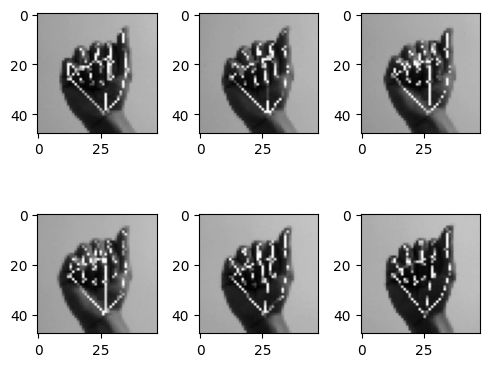

In [158]:
f, ax = plt.subplots(2,3) 
f.set_size_inches(5, 5)
k = 0
for i in range(2):
    for j in range(3):
        ax[i,j].imshow(X_train[k] , cmap = "gray")
        k += 1
    plt.tight_layout()   

## Convert Labels to Binary

In [159]:
lb = LabelBinarizer()
y_train = lb.fit_transform(train_label)
y_test = lb.fit_transform(test_label)

## Data Augmentation

In [133]:
X_train.mean()

0.0018968628275400172

In [161]:
datagen = ImageDataGenerator(
    rescale=1/255,
    horizontal_flip=True,
    zoom_range=0.1,
    rotation_range=3,
    height_shift_range=0.2,
    width_shift_range=0.2
)

datagen.fit(X_train)

In [134]:
datagen = ImageDataGenerator(rescale = 1./255,
                                  rotation_range = 0,
                                  height_shift_range=0.2,
                                  width_shift_range=0.2,
                                  shear_range=0,
                                  zoom_range=0.2,
                                  horizontal_flip=True,
                                  fill_mode='nearest')


datagen.fit(X_train)

In [144]:
datagen = ImageDataGenerator(rotation_range=3,
                            zoom_range = 0.1,
                            width_shift_range=0.1,
                            height_shift_range=0.1,
                            horizontal_flip=False)


datagen.fit(X_train)

# Creating our Convolutional Neural Network

## Attempt 3

In [164]:
model = Sequential()
model.add(Conv2D(128, kernel_size=(5,5),
                 strides=1, padding='same', activation='relu', input_shape=(48,48,1)))
model.add(MaxPool2D(pool_size=(4,4), strides=2, padding='same'))
model.add(Conv2D(64, kernel_size=(2,2),
                 strides=1, activation='relu', padding='same'))
model.add(MaxPool2D((4,4), 2, padding='same'))
model.add(Conv2D(32, kernel_size=(2,2),
                 strides=1, activation='relu', padding='same'))
model.add(MaxPool2D((4,4), 2, padding='same'))
          
model.add(Flatten())
model.add(Dense(units=512,activation='relu'))
model.add(Dropout(rate=0.25))
# model.add(Dense(units=24,activation='softmax'))
model.add(Dense(units=4,activation='softmax'))
model.summary()

model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 48, 48, 128)       3328      
                                                                 
 max_pooling2d_18 (MaxPooli  (None, 24, 24, 128)       0         
 ng2D)                                                           
                                                                 
 conv2d_19 (Conv2D)          (None, 24, 24, 64)        32832     
                                                                 
 max_pooling2d_19 (MaxPooli  (None, 12, 12, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_20 (Conv2D)          (None, 12, 12, 32)        8224      
                                                                 
 max_pooling2d_20 (MaxPooli  (None, 6, 6, 32)         

In [165]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.5, min_lr=0.00001)

model.fit(datagen.flow(X_train, y_train, batch_size=128),
          epochs = 20,
          validation_data=(X_test, y_test),
          shuffle=1,
          callbacks = [learning_rate_reduction]
         )

Epoch 1/20
92/92 [==============================] - 41s 438ms/step - loss: 1.1577 - accuracy: 0.4969 - val_loss: 3.2485 - val_accuracy: 0.5019 - lr: 0.0010
Epoch 2/20
92/92 [==============================] - 42s 455ms/step - loss: 1.1410 - accuracy: 0.5037 - val_loss: 2.6970 - val_accuracy: 0.5019 - lr: 0.0010
Epoch 3/20
92/92 [==============================] - ETA: 0s - loss: 1.1410 - accuracy: 0.5037
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
92/92 [==============================] - 41s 448ms/step - loss: 1.1410 - accuracy: 0.5037 - val_loss: 1.5590 - val_accuracy: 0.5019 - lr: 0.0010
Epoch 4/20
92/92 [==============================] - 42s 454ms/step - loss: 1.1378 - accuracy: 0.5037 - val_loss: 1.6098 - val_accuracy: 0.5019 - lr: 5.0000e-04
Epoch 5/20
92/92 [==============================] - ETA: 0s - loss: 1.1375 - accuracy: 0.5037
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
92/92 [==============================] - 41

In [143]:
print("Accuracy of the model is - " , model.evaluate(X_test,y_test)[1]*100 , "%")

35/35 [==============================] - 1s 26ms/step - loss: 1.1431 - accuracy: 0.5036
Accuracy of the model is -  50.35714507102966 %


In [84]:
model.save("asl_mnist_98.h5")

D:\Anaconda3\envs\sc4031\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Attempt 2

In [35]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.5, min_lr=0.00001)

model.fit(datagen.flow(X_train, y_train, batch_size=128),
          epochs = 20,
          validation_data=(X_test, y_test),
          shuffle=1,
          callbacks = [learning_rate_reduction]
         )

Epoch 1/20
2/2 [==============================] - 0s 229ms/step - loss: 1.3830 - accuracy: 0.2762 - val_loss: 3.2101 - val_accuracy: 0.2568 - lr: 0.0010
Epoch 2/20
2/2 [==============================] - 0s 158ms/step - loss: 1.3822 - accuracy: 0.2762 - val_loss: 3.4889 - val_accuracy: 0.2568 - lr: 0.0010
Epoch 3/20
2/2 [==============================] - ETA: 0s - loss: 1.3819 - accuracy: 0.2762
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
2/2 [==============================] - 0s 187ms/step - loss: 1.3819 - accuracy: 0.2762 - val_loss: 3.8470 - val_accuracy: 0.2568 - lr: 0.0010
Epoch 4/20
2/2 [==============================] - 0s 145ms/step - loss: 1.3811 - accuracy: 0.2762 - val_loss: 4.0644 - val_accuracy: 0.2568 - lr: 5.0000e-04
Epoch 5/20
2/2 [==============================] - ETA: 0s - loss: 1.3809 - accuracy: 0.2762
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
2/2 [==============================] - 0s 147ms/step - loss

In [36]:
print("Accuracy of the model is - " , model.evaluate(X_test,y_test)[1]*100 , "%")

3/3 [==============================] - 0s 11ms/step - loss: 5.0993 - accuracy: 0.2568
Accuracy of the model is -  25.67567527294159 %


In [37]:
model.save("test_model.h5")

D:\Anaconda3\envs\sc4031\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Attempt 1 (Fail?)

In [73]:
model.fit(datagen.flow(X_train, y_train, batch_size=128),
          epochs = 20,
          validation_data=(X_test, y_test),
          shuffle=1
         )

Epoch 1/20
215/215 [==============================] - 45s 199ms/step - loss: 3.1769 - accuracy: 0.0471 - val_loss: 3.2569 - val_accuracy: 0.0201
Epoch 2/20
215/215 [==============================] - 42s 194ms/step - loss: 3.1760 - accuracy: 0.0463 - val_loss: 3.2713 - val_accuracy: 0.0201
Epoch 3/20
215/215 [==============================] - 39s 180ms/step - loss: 3.1760 - accuracy: 0.0460 - val_loss: 3.2698 - val_accuracy: 0.0201
Epoch 4/20
215/215 [==============================] - 39s 180ms/step - loss: 3.1759 - accuracy: 0.0453 - val_loss: 3.2767 - val_accuracy: 0.0201
Epoch 5/20
215/215 [==============================] - 40s 185ms/step - loss: 3.1761 - accuracy: 0.0467 - val_loss: 3.2727 - val_accuracy: 0.0201
Epoch 6/20
215/215 [==============================] - 39s 179ms/step - loss: 3.1760 - accuracy: 0.0453 - val_loss: 3.2780 - val_accuracy: 0.0201
Epoch 7/20
215/215 [==============================] - 39s 179ms/step - loss: 3.1759 - accuracy: 0.0460 - val_loss: 3.2783 - val_ac

### Model Evaluation

In [81]:
score = model.evaluate(X_test, y_test, verbose=0)
print(f'Test Accuracy: {score[1]*100}%')

Test Accuracy: 15.658114850521088%


# Webcam Test with Mediapipe

## Load Model (if needed)

In [2]:
model = load_model("./output/asl_mnist_100.h5")
# model = load_model("./output/asl_mnist_98.h5")

## Setup Mediapipe

In [2]:
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils

hands = mp_hands.Hands()

## Pre-Process Image/Frame

In [54]:
def preprocess_image(frame):
    # Convert image to RGB format
    img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    
    # Normalize pixel values to [0, 1]
    img = img.astype(np.float32) / 255.0

    # Resize (just need 28x28 since our dataset has a total of 784 pixels)
    img = cv2.resize(img, (28, 28))

    # Reshape
    # img = np.reshape(img, (-1, 28, 28, 1))
    
    return img

In [55]:
def convert_img_to_pixels(img):
    pixel_list = []
    rows, cols = img.shape

    for i in range(rows):
        for j in range(cols):
            pixel_value = img[i, j]
            pixel_list.append(pixel_value)

    img_pd = pd.DataFrame(pixel_list).T

    # Generate column names (784 columns for each pixel)
    pixel_cols = []
    for val in range(784):
        pixel_cols.append(val)

    # Set pd columns as pixel numbers
    img_pd.columns = pixel_cols

    predict_data = img_pd.values
    predict_data = predict_data.reshape(-1, 28, 28, 1)
    predict_data = predict_data / 255 # Normalize to [0, 1]

    return predict_data

## Load Video Capture

In [3]:
import time
import math
from cvzone.HandTrackingModule import HandDetector

label_list = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y']

## Use cvzone

In [57]:
cap = cv2.VideoCapture(0)
detector = HandDetector(maxHands=1)
IMG_SIZE = 300

while True:
    success, frame = cap.read()
    hands, frame = detector.findHands(frame)

    if hands:
        hand = hands[0]
        x, y, w, h = hand['bbox']

        # Get bounding box for detected hand
        offset = 20
        frame_crop = frame[y-offset:y+h+offset, x-offset:x+w+offset]
        frame_crop_shape = frame_crop.shape
        
        frame_white = np.ones((IMG_SIZE, IMG_SIZE, 3), np.uint8) * 255
    
        aspect_ratio = h/w

        if aspect_ratio > 1:
            k = IMG_SIZE/h
            w_cal = math.ceil(k*w)
            w_gap = math.ceil((IMG_SIZE-w_cal)/2)

            frame_resize = cv2.resize(frame_crop, (w_cal, IMG_SIZE))
            frame_resize_shape = frame_resize.shape
            
            if frame_crop_shape[0] <= 300 and frame_crop_shape[1] <= 300:
                frame_white[:, w_gap:w_cal+w_gap] = frame_resize

        else:
            k = IMG_SIZE/w
            h_cal = math.ceil(k*h)
            h_gap = math.ceil((IMG_SIZE-h_cal)/2)

            frame_resize = cv2.resize(frame_crop, (IMG_SIZE, h_cal))
            frame_resize_shape = frame_resize.shape
            
            if frame_crop_shape[0] <= 300 and frame_crop_shape[1] <= 300:
                frame_white[h_gap:h_cal+h_gap, :] = frame_resize

        cv2.imshow("Cropped", frame_crop)
        cv2.imshow("White", frame_white)
        
    
    cv2.imshow("Webcam", frame)

    key = cv2.waitKey(1)

    # if(key == ord('q')):
    #     break
    # elif(key == ord('s')):
    #     cv2.imwrite(f'./output/training/A/A_{time.time()}.jpg', frame_white)

    # Break the loop when 'q' is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
    elif cv2.waitKey(1) & 0xFF == ord('s'):
        cv2.imwrite(f'./output/training/{time.time()}.jpg', frame_white)

# Release the webcam and close all windows
cap.release()
cv2.destroyAllWindows()

## Use Mediapipe

In [199]:
cap = cv2.VideoCapture(0)
label_list = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y']


with mp_hands.Hands() as hands:
    while True:
        # Capture frame by frame
        ret, frame = cap.read()
        h, w, c = frame.shape

        # img = preprocess_image(frame)
        img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = hands.process(img)

        hand_landmarks = results.multi_hand_landmarks
        if hand_landmarks:
            analysis_frame = frame

            for hand_lm in hand_landmarks:
                mp_drawing.draw_landmarks(frame, hand_lm, mp_hands.HAND_CONNECTIONS)
                
                x_max = 0
                y_max = 0
                x_min = w
                y_min = h
                for lm in hand_lm.landmark:
                    x, y = int(lm.x * w), int(lm.y * h)
                    if x > x_max:
                        x_max = x
                    if x < x_min:
                        x_min = x
                    if y > y_max:
                        y_max = y
                    if y < y_min:
                        y_min = y
                        
                y_min -= 20
                y_max += 20
                x_min -= 20
                x_max += 20

                # Calculate the max length of square bounding box
                hand_width = x_max - x_min
                hand_height = y_max - y_min
                side_length = max(hand_width, hand_height)

                # Calculate the coordinates of the top-left corner of the square
                x_square = x_min + (hand_width - side_length) // 2
                y_square = y_min + (hand_height - side_length) // 2

                # Get bounding box coords
                x_start = x_square - offset
                y_start = y_square - offset
                x_end = x_square + side_length + offset
                y_end = y_square + side_length + offset

                # cv2.rectangle(frame, (x_start, y_start), (x_end, y_end), (0, 255, 0), 2)

                # Crop out hand only from frame
                cropped = frame[y_start:y_end, x_start:x_end]

                if cropped.shape[0] > 0 and cropped.shape[1] > 0:
                    cv2.imshow("Cropped", cropped)

        
        cv2.imshow('Webcam', frame)

        key = cv2.waitKey(1)
        
        # Break the loop when 'q' is pressed
        if key == ord('q'):
            break
        elif key == ord('s'):
            if cropped.shape[0] > 0 and cropped.shape[1] > 0:
                cv2.imwrite(f'./output/train/{time.time()}.jpg', cropped)

# Release the webcam and close all windows
cap.release()
cv2.destroyAllWindows()

In [167]:
model = load_model("./output/model.h5")

cap = cv2.VideoCapture(0)
# label_list = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y']
label_list = ['A', 'B', 'C', 'D']

with mp_hands.Hands() as hands:
    while True:
        # Capture frame by frame
        ret, frame = cap.read()
        h, w, c = frame.shape

        # img = preprocess_image(frame)
        img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = hands.process(img)

        #if cv2.waitKey(1) & 0xFF == ord('f'):
        # Check Left or Right
        #print(f"Handedness: ${results.multi_handedness}")

        hand_landmarks = results.multi_hand_landmarks
        if hand_landmarks:
            analysis_frame = frame

            for hand_lm in hand_landmarks:
                x_max = 0
                y_max = 0
                x_min = w
                y_min = h
                for lm in hand_lm.landmark:
                    x, y = int(lm.x * w), int(lm.y * h)
                    if x > x_max:
                        x_max = x
                    if x < x_min:
                        x_min = x
                    if y > y_max:
                        y_max = y
                    if y < y_min:
                        y_min = y
                        
                y_min -= 20
                y_max += 20
                x_min -= 20
                x_max += 20
                cv2.rectangle(frame, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
                mp_drawing.draw_landmarks(frame, hand_lm, mp_hands.HAND_CONNECTIONS)
            
            if cv2.waitKey(1) & 0xFF == ord('f'):    
                # Set Frame to Analyse as Cropped Hand
                # analysis_frame = cv2.cvtColor(frame[y_min:y_max, x_min:x_max], cv2.COLOR_BGR2GRAY)'

                
                analysis_frame = cv2.cvtColor(analysis_frame, cv2.COLOR_BGR2GRAY)
                analysis_frame = analysis_frame[y_min:y_max, x_min:x_max]

                if(analysis_frame.size):
                    analysis_frame = cv2.resize(analysis_frame, (28, 28))
    
                    # Pre-process image for prediction 
                    # analysis_frame = preprocess_image(analysis_frame)
    
                    predict_frame = convert_img_to_pixels(analysis_frame)
            
                    # Prediction
                    predictions = model.predict(predict_frame)
                    pred_array = np.array(predictions[0])
    
                    label_list_dict = {label_list[i]: pred_array[i] for i in range(len(label_list))}
    
                    pred_array_ordered = sorted(pred_array, reverse=True)

                    print(pred_array_ordered[0])
    
                    for key, value in label_list_dict.items():
                        print(value)
                        if value == pred_array_ordered[0]:
                            #print("Predicted Character 1: ", key)
                            #print('Confidence 1: ', 100*value)
                            cv2.putText(frame, key, (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
                            
                        #elif value == pred_array_ordered[1]:
                            #print("Predicted Character 2: ", key)
                            #print('Confidence 2: ', 100*value)
                            
                        #elif value == pred_array_ordered[2]:
                            #print("Predicted Character 3: ", key)
                            #print('Confidence 3: ', 100*value)

        
        cv2.imshow('Webcam', frame)
    
        # Break the loop when 'q' is pressed
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break 

# Release the webcam and close all windows
cap.release()
cv2.destroyAllWindows()

NameError: name 'convert_img_to_pixels' is not defined

In [186]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 48, 48, 128)       3328      
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 24, 24, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 24, 24, 64)        32832     
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 12, 12, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 12, 12, 32)        8224      
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 6, 6, 32)         

In [174]:
IMG_SIZE = 48

In [21]:
def extract_features(img):
    features = np.array(img)
    features = features.reshape(1, 48, 48, 1)
    features = features/255.0

    return features

In [22]:
offset = 20

model = load_model("./models/model_all_alpha_85.h5")

cap = cv2.VideoCapture(0)
labels = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y']
# labels = ['A', 'B', 'C', 'D']

predicted_label = ""

with mp_hands.Hands() as hands:
    while True:
        # Capture frame by frame
        ret, frame = cap.read()
        h, w, c = frame.shape

        # img = preprocess_image(frame)
        img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = hands.process(img)

        #if cv2.waitKey(1) & 0xFF == ord('f'):
        # Check Left or Right
        #print(f"Handedness: ${results.multi_handedness}")

        hand_landmarks = results.multi_hand_landmarks
        if hand_landmarks:
            analysis_frame = frame

            for hand_lm in hand_landmarks:
                mp_drawing.draw_landmarks(frame, hand_lm, mp_hands.HAND_CONNECTIONS)
                
                x_max = 0
                y_max = 0
                x_min = w
                y_min = h
                for lm in hand_lm.landmark:
                    x, y = int(lm.x * w), int(lm.y * h)
                    if x > x_max:
                        x_max = x
                    if x < x_min:
                        x_min = x
                    if y > y_max:
                        y_max = y
                    if y < y_min:
                        y_min = y
                        
                y_min -= 20
                y_max += 20
                x_min -= 20
                x_max += 20

                # Calculate the max length of square bounding box
                hand_width = x_max - x_min
                hand_height = y_max - y_min
                side_length = max(hand_width, hand_height)

                # Calculate the coordinates of the top-left corner of the square
                x_square = x_min + (hand_width - side_length) // 2
                y_square = y_min + (hand_height - side_length) // 2

                # Get bounding box coords
                x_start = x_square - offset
                y_start = y_square - offset
                x_end = x_square + side_length + offset
                y_end = y_square + side_length + offset

                # Crop out hand only from frame
                cropped = frame[y_start:y_end, x_start:x_end]

                if cropped.shape[0] > 0 and cropped.shape[1] > 0:
                    cv2.imshow("Cropped", cropped)
            
            if key == ord('f'):    
                # Set Frame to Analyse as Cropped Hand
                if cropped.shape[0] > 0 and cropped.shape[1] > 0:
                    predict_frame = cropped
                    predict_frame = cv2.cvtColor(predict_frame, cv2.COLOR_BGR2GRAY)
                    predict_frame = cv2.resize(predict_frame, (48, 48))
                    predict_frame = extract_features(predict_frame)

                    predictions = model.predict(predict_frame)
                    pred_array = np.array(predictions)
                    print(pred_array)
                    
                    predicted_class_index = np.argmax(predictions)
                    # Map the predicted index to class label
                    predicted_label = labels[predicted_class_index]
                    
                    # Print the predicted label
                    print("Predicted label:", predicted_label)

            if(predicted_label is not None):
                cv2.putText(frame, predicted_label, (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

        
        cv2.imshow('Webcam', frame)
            
        key = cv2.waitKey(1)
        
        # Break the loop when 'q' is pressed
        if key == ord('q'):
            break
        elif key == ord('s'):
            if cropped.shape[0] > 0 and cropped.shape[1] > 0:
                cv2.imwrite(f'./output/train/{time.time()}.jpg', cropped)

# Release the webcam and close all windows
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 407ms/step
[[8.89171279e-05 2.55188435e-01 5.93396499e-06 2.29550351e-04
  1.37345836e-04 2.50514954e-01 1.67837424e-08 5.28649130e-12
  5.54786311e-06 3.01059772e-05 2.09349267e-08 4.73012335e-07
  2.30152689e-10 2.18898730e-08 1.38497558e-09 2.28065300e-09
  3.22184997e-06 1.11380416e-07 2.54371013e-08 1.18167072e-05
  1.41453918e-03 4.92368966e-01 5.78426693e-08 2.41684024e-08]]
Predicted label: W
1/1 [==============================] - 0s 23ms/step
[[1.67941785e-08 9.95149553e-01 3.40671359e-05 4.05319151e-05
  1.06535103e-04 4.09254571e-03 1.00581536e-10 1.88016592e-16
  2.27003638e-10 8.66045298e-08 2.43033892e-11 3.31589096e-11
  9.55334878e-13 3.85990649e-11 4.87498757e-11 1.99623595e-10
  9.38184144e-07 2.63851319e-09 8.74370541e-12 3.33207277e-06
  6.62348725e-07 5.71676646e-04 3.84439991e-09 4.46504304e-14]]
Predicted label: B
1/1 [==============================] - 0s 22ms/step
[[3.6753896e-08 9.9359351e-01 6.7855348e-05 4.3242973e-05

## Test with Image

In [2]:
import time
import math
import cv2
import mediapipe as mp
from cvzone.HandTrackingModule import HandDetector

label_list = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y']
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils

labels = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y']
# labels = ['A', 'B', 'C', 'D']

frame = cv2.imread("./belaaa.jpg")
img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

with mp_hands.Hands(max_num_hands=1) as hands:
    results = hands.process(frame)
    hand_landmarks = results.multi_hand_landmarks

    if hand_landmarks:
        # print("found hand")
        # cv2.imshow("image", frame)
        for hand_lm in hand_landmarks:
            mp_drawing.draw_landmarks(frame, hand_lm, mp_hands.HAND_CONNECTIONS)

        while True:
            cv2.imshow("image", frame)

            key = cv2.waitKey(1)
                
            if key == ord('q'):
                break
    else:
        print("no hand detected")
        
    # key = cv2.waitKey(1)
        
    # if key == ord('q'):
    #     break
            
# cv2.destroyAllWindows()

no hand detected
